## Enunciado

> Considere la información del proyecto cuya información aparece en la tabla adjunta:
> 1. ¿Cuál es la probabilidad de terminar el proyecto entre 17 y 19 semanas?
> 2. Como la probabilidad antes calculada le parece baja, reduzca, con mínimo coste la duración media del proyecto a 18 semanas. ¿Cuál será ahora la probabilidad de terminar en 18 semanas? ¿Por qué?
> 3. ¿Se encuentran nivelados los recursos consumidos por este proyecto antes de reducir su duración a 18 semanas? De no ser así proceda a su nivelación (analice únicamente dos actividades).
> 4. Si su empresa sólo puede destinar a 6 personas a este proyecto, ¿se encuentran los recursos de mano de obra correctamente asignados tras la nivelación? Reprográmelo si fuera necesario de modo que se cumpla esta restricción.

In [1]:
!apt install libgraphviz-dev              > /dev/null
%pip install pygraphviz "pandas[excel]"   > /dev/null
%pip install numpyarray_to_latex          > /dev/null

repo_url = 'https://github.com/mcasl/pmULE'
repo_name = "pmULE"

import os, sys

if not os.path.exists(repo_name):
    print(f"Cloning repository '{repo_name}'...")
    !git clone {repo_url}
    print("Repository cloned successfully!")
else:
    print(f"Good! No need to download '{repo_name}' again.")

from google.colab import files

# To find local version of the library
sys.path.append('pmULE/src')

from pmule import PredecessorTable, ProjectGraph



Cloning repository 'pmULE'...
Cloning into 'pmULE'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 254 (delta 31), reused 7 (delta 2), pack-reused 191 (from 1)
Receiving objects: 100% (254/254), 9.69 MiB | 11.31 MiB/s, done.
Resolving deltas: 100% (132/132), done.
Repository cloned successfully!


In [2]:
%load_ext autoreload

# Alargamos el ancho de las celdas al 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import pandas as pd
import numpy as np
pd.set_option('future.no_silent_downcasting', True)

datos_enunciado = pd.DataFrame([
#  actividad, precedentes, duracion, varianza,  cur,  recursos, duracion_tope
     ('A',       '---  ',      2,        1,     -100,     2,         1        ),
     ('B',       '---  ',      4,        1,       30,     2,         2        ),
     ('C',       'B    ',      1,        1,   np.inf,     2,         1        ),
     ('D',       'A    ',      3,        1,       50,     2,         1        ),
     ('E',       'B,D  ',      7,        1,       20,     2,         4        ),
     ('F',       'C    ',      4,        1,       10,     2,         2        ),
     ('G',       '---  ',      1,        2,      100,     4,         1        ),
     ('H',       'G    ',     11,        2,       10,     2,         8        ),
     ('I',       'E,F,H',      2,        1,       50,     2,         1        ),
     ('J',       'E,F,H',      8,        1,        5,     2,         7        ),
] ,columns=['activity', 'predecessor', 'duration', 'variance', 'ucr', 'resources', 'crash_duration']).set_index('activity')

datos_enunciado

,predecessor,duration,variance,ucr,resources,crash_duration
activity,,,,,,
A,---,2,1,-100.0,2,1
B,---,4,1,30.0,2,2
C,B,1,1,inf,2,1
D,A,3,1,50.0,2,1
E,"B,D",7,1,20.0,2,4
F,C,4,1,10.0,2,2
G,---,1,2,100.0,4,1
H,G,11,2,10.0,2,8
I,"E,F,H",2,1,50.0,2,1


## Solución
### Apartado 1

> ¿Cuál es la probabilidad de terminar el proyecto entre 17 y 19 semanas?




#### Duración media del proyecto

La clase PertGraph permite visualizar el grafo PERT, el diagrama de Gantt así como realizar el cálculo de tiempos tempranos, tardíos y de las holguras totales.

In [3]:
%autoreload 2
from pmule import PredecessorTable, ProjectGraph

In [4]:
datos_proyecto = datos_enunciado.copy()
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto, activity='activity', predecessor='predecessor')
prelaciones.display_immediate_linkage_matrix()

,A,B,C,D,E,F,G,H,I,J
activities,,,,,,,,,,
A,,,,,,,,,,
B,,,,,,,,,,
C,,True,,,,,,,,
D,True,,,,,,,,,
E,,True,,True,,,,,,
F,,,True,,,,,,,
G,,,,,,,,,,
H,,,,,,,True,,,
I,,,,,True,True,,True,,


In [5]:
proyecto = prelaciones.create_project()

##### Grafo PERT con numeración de nodos

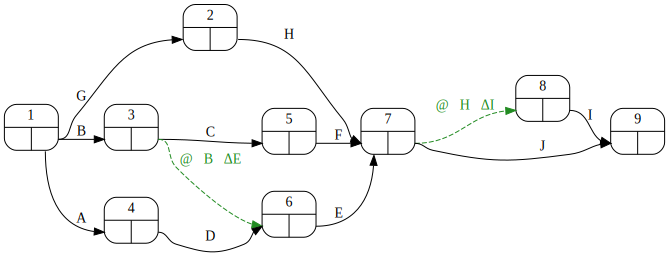

In [6]:
proyecto.pert()

##### Matriz de Zaderenko

In [7]:
proyecto.zaderenko(durations=datos_proyecto['duration'])

,1,2,3,4,5,6,7,8,9,early
1,,1.0,4.0,2.0,,,,,,0.0
2,,,,,,,11.0,,,1.0
3,,,,,1.0,0.0,,,,4.0
4,,,,,,3.0,,,,2.0
5,,,,,,,4.0,,,5.0
6,,,,,,,7.0,,,5.0
7,,,,,,,,0.0,8.0,12.0
8,,,,,,,,,2.0,12.0
9,,,,,,,,,,20.0
late,0.0,1.0,5.0,2.0,8.0,5.0,12.0,18.0,20.0,


In [8]:
resultados_pert = proyecto.calculate_pert(durations=datos_proyecto['duration'])
resultados_pert['nodes']

,early,late
1,0,0
2,1,1
3,4,5
4,2,2
5,5,8
6,5,5
7,12,12
8,12,18
9,20,20


##### Duración media del proyecto

La duración media del proyecto es:

In [9]:
duracion_media_proyecto = proyecto.duration(durations=datos_proyecto['duration'])
duracion_media_proyecto

20

#### Varianza de la duración del proyecto
Para determinar la varianza de la duración del proyecto es necesario determinar la varianza de cada rama del camino crítico.

##### Holguras

In [10]:
resultados_pert['activities']

,H_total
@∇B⤑ΔE,1
@∇H⤑ΔI,6
A,0
B,1
C,3
D,0
E,0
F,3
G,0
H,0


##### Camino crítico

In [11]:
camino_critico = proyecto.critical_path(datos_proyecto['duration'])
camino_critico

{'Route_1': ['G', 'H', 'J'], 'Route_7': ['A', 'D', 'E', 'J']}

In [12]:
desviacion_proyecto = proyecto.standard_deviation(durations=datos_proyecto['duration'],
                                                  variances=datos_proyecto['variance'])
desviacion_proyecto

Variance path: Route_1 : 5
Variance path: Route_7 : 4
Project duration variance: 5
Project duration standard deviation: 2.23606797749979


2.23606797749979

#### Probabilidad de terminar entre 17 y 19 periodos

In [13]:
import scipy
from scipy.stats import norm

probabilidad_de_terminar_antes_de_19 = norm.cdf(19, loc=duracion_media_proyecto, scale=desviacion_proyecto)
probabilidad_de_terminar_antes_de_17 = norm.cdf(17, loc=duracion_media_proyecto, scale=desviacion_proyecto)

probabilidad_de_terminar_entre_17_y_19 = probabilidad_de_terminar_antes_de_19 - probabilidad_de_terminar_antes_de_17
probabilidad_de_terminar_entre_17_y_19 * 100

23.75041755697886

### Apartado 2
> Como la probabilidad antes calculada le parece baja, reduzca, con mínimo coste la duración media del proyecto a 18 semanas.
¿Cuál será ahora la probabilidad de terminar en 18 semanas? ¿Y la probabilidad de terminar entre 19 y 17 semanas?



#### Reducción a 18 periodos

In [14]:
ackoff, best_option, duration, available = proyecto.ackoff(durations=datos_proyecto['duration'],
                min_durations=datos_proyecto['crash_duration'],
                costs=datos_proyecto['ucr'],
                reduction=2)
ackoff

D shape (10,)
Path matrix shape (8, 10)


Step: 0,	 Best option: ['J', 'A'], 	 Cost: -95.0, 	 Critical paths: ['Route_1', 'Route_7']
Step: 1,	 Best option: ['H'], 	 Cost: 10.0, 	 Critical paths: ['Route_1']





,A,B,C,D,E,F,G,H,I,J,0,1,2
Route_1,,,,,,,100.0,10.0,,5.0,20.0,19.0,18.0
Route_2,,,,,,,100.0,10.0,50.0,,14.0,14.0,13.0
Route_3,,30.0,inf,,,10.0,,,,5.0,17.0,16.0,16.0
Route_4,,30.0,inf,,,10.0,,,50.0,,11.0,11.0,11.0
Route_5,,30.0,,,20.0,,,,,5.0,19.0,18.0,18.0
Route_6,,30.0,,,20.0,,,,50.0,,13.0,13.0,13.0
Route_7,-100.0,,,50.0,20.0,,,,,5.0,20.0,18.0,18.0
Route_8,-100.0,,,50.0,20.0,,,,50.0,,14.0,13.0,13.0
0,1.0,2.0,0.0,2.0,3.0,2.0,0.0,3.0,1.0,1.0,,,
1,0.0,2.0,0.0,2.0,3.0,2.0,0.0,3.0,1.0,0.0,,,


#### Probabilidad de terminar antes de 18 periodos
Al ser 18 el valor de la media de la duración, la probabilidad pedida es del 50%.

#### Probabilidad de terminar entre 19 y 17 semanas

##### Duración media del proyecto

Nótese como al haber reducido la duración del proyecto la duración media a utilizar en el cálculo de la probabilidad es la nueva duración recortada de 18 periodos.

In [15]:
duracion_media_proyecto = proyecto.duration(durations=duration)
duracion_media_proyecto

18

##### Varianza de la duración del proyecto

In [16]:
desviacion_proyecto = proyecto.standard_deviation(durations=duration,
                                                  variances=datos_proyecto['variance'])
desviacion_proyecto

Variance path: Route_1 : 5
Variance path: Route_5 : 3
Variance path: Route_7 : 4
Project duration variance: 5
Project duration standard deviation: 2.23606797749979


2.23606797749979

En este caso la varianza de la nueva rama es inferior a la ya calculada para el proyecto.

##### Cálculo de la probabilidad

In [17]:
import scipy
from scipy.stats import norm

probabilidad_de_terminar_antes_de_19 = norm.cdf(19, loc=duracion_media_proyecto, scale=desviacion_proyecto)
probabilidad_de_terminar_antes_de_17 = norm.cdf(17, loc=duracion_media_proyecto, scale=desviacion_proyecto)

probabilidad_de_terminar_entre_17_y_19 = probabilidad_de_terminar_antes_de_19 - probabilidad_de_terminar_antes_de_17
probabilidad_de_terminar_entre_17_y_19 * 100

34.527915398142305

### Apartado 3
> ¿Se encuentran nivelados los recursos consumidos por este proyecto antes de reducir su duración a 18 semanas? De no ser así proceda a su nivelación (analice únicamente dos actividades).

#### Análisis de la situación inicial

Para responder este apartado es necesario representar la demanda de recursos a lo largo del tiempo.

In [18]:
proyecto_nivelacion = proyecto.copy()
duration_resources = datos_enunciado[['duration','resources']].copy()
proyecto_nivelacion.gantt(data=duration_resources,
                          duration_label='duration',
                          resource_label='resources',
                          total='fila' )

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
A,2,2,,,,,,,,,,,,,,,,,,
B,2,2,2,2,,,,,,,,,,,,,,,,
C,,,,,2,,,,,,,,,,,,,,,
D,,,2,2,2,,,,,,,,,,,,,,,
E,,,,,,2,2,2,2,2,2,2,,,,,,,,
F,,,,,,2,2,2,2,,,,,,,,,,,
G,4,,,,,,,,,,,,,,,,,,,
H,,2,2,2,2,2,2,2,2,2,2,2,,,,,,,,
I,,,,,,,,,,,,,2,2,,,,,,
J,,,,,,,,,,,,,2,2,2,2,2,2,2,2


La demanda de recursos actual no se encuentra nivelada. Se procede a aplicar el algoritmo de nivelación.

Se comienza buscando la actividad no crítica con su final más temprano más próximo al final del proyecto.

In [19]:
(proyecto.calendar(duration_resources['duration'])
 .loc[:, ['fin_mas_temprano', 'H_total']]
 .sort_values(by='fin_mas_temprano', ascending=False)
 .query('H_total > 0')
)

,fin_mas_temprano,H_total
activity,,
I,14,6
F,9,3
C,5,3
B,4,1


Esta primera actividad en la que actuar es al I. Puede apreciarse también directamente en el diagrama de Gantt anterior.

#### Nivelación de los recursos

##### Primera actividad: I

In [20]:
proyecto_nivelacion.evaluar_rango_de_desplazamientos(duration_resources, 'duration', 'resources',  'I')

Sin desplazar:
Suma de cuadrados: 456 

Desplazamiento: 1
Suma de cuadrados: 456.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,H_total
A,2.000000,2.000000,,,,,,,,,,,,,,,,,,,0.000000
B,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,1.000000
C,,,,,2.000000,,,,,,,,,,,,,,,,3.000000
D,,,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,0.000000
E,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
F,,,,,,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,3.000000
G,4.000000,,,,,,,,,,,,,,,,,,,,0.000000
H,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
I,,,,,,,,,,,,,,2.000000,2.000000,,,,,,5.000000
J,,,,,,,,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000


Desplazamiento: 2
Suma de cuadrados: 456.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,H_total
A,2.000000,2.000000,,,,,,,,,,,,,,,,,,,0.000000
B,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,1.000000
C,,,,,2.000000,,,,,,,,,,,,,,,,3.000000
D,,,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,0.000000
E,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
F,,,,,,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,3.000000
G,4.000000,,,,,,,,,,,,,,,,,,,,0.000000
H,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
I,,,,,,,,,,,,,,,2.000000,2.000000,,,,,4.000000
J,,,,,,,,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000


Desplazamiento: 3
Suma de cuadrados: 456.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,H_total
A,2.000000,2.000000,,,,,,,,,,,,,,,,,,,0.000000
B,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,1.000000
C,,,,,2.000000,,,,,,,,,,,,,,,,3.000000
D,,,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,0.000000
E,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
F,,,,,,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,3.000000
G,4.000000,,,,,,,,,,,,,,,,,,,,0.000000
H,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
I,,,,,,,,,,,,,,,,2.000000,2.000000,,,,3.000000
J,,,,,,,,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000


Desplazamiento: 4
Suma de cuadrados: 456.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,H_total
A,2.000000,2.000000,,,,,,,,,,,,,,,,,,,0.000000
B,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,1.000000
C,,,,,2.000000,,,,,,,,,,,,,,,,3.000000
D,,,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,0.000000
E,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
F,,,,,,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,3.000000
G,4.000000,,,,,,,,,,,,,,,,,,,,0.000000
H,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
I,,,,,,,,,,,,,,,,,2.000000,2.000000,,,2.000000
J,,,,,,,,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000


Desplazamiento: 5
Suma de cuadrados: 456.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,H_total
A,2.000000,2.000000,,,,,,,,,,,,,,,,,,,0.000000
B,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,1.000000
C,,,,,2.000000,,,,,,,,,,,,,,,,3.000000
D,,,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,0.000000
E,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
F,,,,,,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,3.000000
G,4.000000,,,,,,,,,,,,,,,,,,,,0.000000
H,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
I,,,,,,,,,,,,,,,,,,2.000000,2.000000,,1.000000
J,,,,,,,,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000


Desplazamiento: 6
Suma de cuadrados: 456.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,H_total
A,2.000000,2.000000,,,,,,,,,,,,,,,,,,,0.000000
B,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,1.000000
C,,,,,2.000000,,,,,,,,,,,,,,,,3.000000
D,,,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,0.000000
E,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
F,,,,,,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,3.000000
G,4.000000,,,,,,,,,,,,,,,,,,,,0.000000
H,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
I,,,,,,,,,,,,,,,,,,,2.000000,2.000000,0.000000
J,,,,,,,,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000


,Suma_de_cuadrados
0,456
1,456
2,456
3,456
4,456
5,456
6,456


La actividad *slide_I* representa el desplazamiento de las actividad I.

Desplazar la actividad I no conlleva ninguna mejora en la nivelación.

##### Segunda actividad: F

Se prosigue desplazando la actividad I otro periodo más al disponer de holgura para una actuación adicional.

In [21]:
proyecto_nivelacion.evaluar_rango_de_desplazamientos(duration_resources, 'duration', 'resources',  'F')

Sin desplazar:
Suma de cuadrados: 456 

Desplazamiento: 1
Suma de cuadrados: 456.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,H_total
A,2.000000,2.000000,,,,,,,,,,,,,,,,,,,0.000000
B,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,1.000000
C,,,,,2.000000,,,,,,,,,,,,,,,,2.000000
D,,,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,0.000000
E,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
F,,,,,,,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,2.000000
G,4.000000,,,,,,,,,,,,,,,,,,,,0.000000
H,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
I,,,,,,,,,,,,,2.000000,2.000000,,,,,,,6.000000
J,,,,,,,,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000


Desplazamiento: 2
Suma de cuadrados: 456.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,H_total
A,2.000000,2.000000,,,,,,,,,,,,,,,,,,,0.000000
B,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,1.000000
C,,,,,2.000000,,,,,,,,,,,,,,,,1.000000
D,,,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,0.000000
E,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
F,,,,,,,,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,1.000000
G,4.000000,,,,,,,,,,,,,,,,,,,,0.000000
H,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
I,,,,,,,,,,,,,2.000000,2.000000,,,,,,,6.000000
J,,,,,,,,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000


Desplazamiento: 3
Suma de cuadrados: 456.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,H_total
A,2.000000,2.000000,,,,,,,,,,,,,,,,,,,0.000000
B,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,0.000000
C,,,,,2.000000,,,,,,,,,,,,,,,,0.000000
D,,,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,0.000000
E,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
F,,,,,,,,,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
G,4.000000,,,,,,,,,,,,,,,,,,,,0.000000
H,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
I,,,,,,,,,,,,,2.000000,2.000000,,,,,,,6.000000
J,,,,,,,,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000


,Suma_de_cuadrados
0,456
1,456
2,456
3,456


Desplazar la actividad F tampoco conlleva ninguna mejora en la nivelación. Sin embargo en el enunciado nos indican que sólo analicemos las primeras dos actividades y por tanto no se continua nivelando.

### Apartado 4
> Si su empresa sólo puede destinar a 6 personas a este proyecto, ¿se encuentran los recursos de mano de obra correctamente asignados tras la nivelación? Reprogramelo si fuera necesario de modo que se cumpla esta restricción.


In [22]:
proyecto_asignacion = proyecto_nivelacion.copy()
duration_resources = datos_enunciado[['duration','resources']].copy()
proyecto_asignacion.gantt(duration_resources, 'duration', 'resources', total='fila', holguras=True)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,H_total
A,2,2,,,,,,,,,,,,,,,,,,,0.000000
B,2,2,2,2,,,,,,,,,,,,,,,,,1.000000
C,,,,,2,,,,,,,,,,,,,,,,3.000000
D,,,2,2,2,,,,,,,,,,,,,,,,0.000000
E,,,,,,2,2,2,2,2,2,2,,,,,,,,,0.000000
F,,,,,,2,2,2,2,,,,,,,,,,,,3.000000
G,4,,,,,,,,,,,,,,,,,,,,0.000000
H,,2,2,2,2,2,2,2,2,2,2,2,,,,,,,,,0.000000
I,,,,,,,,,,,,,2,2,,,,,,,6.000000
J,,,,,,,,,,,,,2,2,2,2,2,2,2,2,0.000000


El proyecto requiere más de 6 personas en el primer periodo. Es necesario aplicar el algorimo de asignación. El primer periodo conflictivo es el 1.

##### Asignación primer periodo

En el primer periodo la actividad B debe ser retrasada un periodo.

In [23]:
duration_resources = proyecto_asignacion.desplazar(duration_resources, 'duration', 'resources', B = 1)

Suma de cuadrados: 448.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,H_total
A,2.000000,2.000000,,,,,,,,,,,,,,,,,,,0.000000
B,,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,0.000000
C,,,,,,2.000000,,,,,,,,,,,,,,,2.000000
D,,,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,0.000000
E,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
F,,,,,,,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,2.000000
G,4.000000,,,,,,,,,,,,,,,,,,,,0.000000
H,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
I,,,,,,,,,,,,,2.000000,2.000000,,,,,,,6.000000
J,,,,,,,,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000


Tras esta actuación el proyecto ya es compatible con la restricción impuesta en los recursos.